In [1]:
import sys
sys.path.append("..")

In [2]:
import wfdb

from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    positions, labels = trigger_points(annotation, with_labels=True)
    return record, positions, labels

def read_records(directory, names, sampto):
    records, positions, labels = [], [],  []
    for name in names:
        path = "/".join([directory, name])
        record, pos, labs = read_record(path, sampto)
        records.append(record)
        positions.append(pos)
        labels.append(labs)
    return records, positions, labels

In [3]:
record_dir = "../physionet.org/files/mitdb/1.0.0"
test_path = '/'.join([record_dir, '106'])
train_names = ["100", "101", "102", "103", "104"]
sampto = None

train_records, train_positions, train_labels = read_records(record_dir, train_names, sampto)
test_record, test_positions, test_labels = read_record(test_path, sampto)

In [4]:
from raccoon.detectors import GarciaBerdonesDetector

detector = GarciaBerdonesDetector(
    name = "GarciaBerdones01",
    batch_size = 32,
    window_size = 20,
    epochs = 3)

detector.train(train_records, train_positions)

Using TensorFlow backend.
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/sit

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
101559/101559 [==============================] - 129s 1ms/step - loss: 0.0293
Epoch 2/3
101559/101559 [==============================] - 127s 1ms/step - loss: 0.0263
Epoch 3/3
101559/101559 [==============================] - 128s 1ms/step - loss: 0.0285


In [5]:
trigger_signal = detector.trigger_signal(test_record)

In [6]:
from raccoon.utils.triggerutils import signal_to_points

detections, certainties = signal_to_points(trigger_signal, with_certainty=True)

In [7]:
import numpy as np

cert_dict = dict(zip(detections, certainties))

abbr = {'N': 'Normal Beat', 'V': 'Premature Ventricular Contraction'}
label_dict = dict(zip(test_positions, [abbr[l] for l in test_labels]))
label_dict[np.nan] = 'False Positive'

In [8]:
from raccoon.utils.evaluationutils import merge
import pandas as pd

df = pd.DataFrame(
    list(merge(test_positions, detections, tolerance=3)),
    columns=["Position", "Detection", "Error"])

df["Certainty"] = df.Detection.map(cert_dict)
df["Label"] = df.Position.map(label_dict)

In [9]:
df

,Position,Detection,Error,Certainty,Label
0,351.0,351.0,TP,0.999986,Normal Beat
1,724.0,724.0,TP,0.997683,Normal Beat
2,1086.0,1086.0,TP,0.999993,Normal Beat
3,1448.0,1448.0,TP,0.999982,Normal Beat
4,1829.0,1829.0,TP,0.999988,Normal Beat
...,...,...,...,...,...
2625,NaN,645464.0,FP,0.956444,False Positive
2626,NaN,645483.0,FP,0.857888,False Positive
2627,NaN,646091.0,FP,0.948910,False Positive
2628,NaN,647876.0,FP,0.950633,False Positive


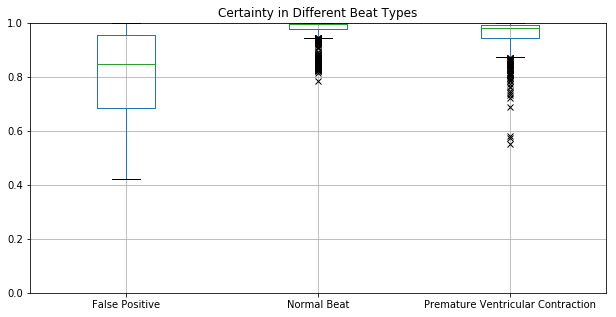

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

df.boxplot(
    column='Certainty', by='Label', ax=ax,
    flierprops=dict(markerfacecolor='b', marker='x'))

ax.set_ylim(0,1)
ax.set_xlabel("")
ax.set_title("Certainty in Different Beat Types")
fig.suptitle("")

ax

In [16]:
fig.savefig(
    '../generated/figures/impact_beat_type.pdf',
    format='pdf',
    bbox_inches = 'tight',
    pad_inches = 0.1)

In [13]:
from scipy.stats import ttest_ind

print(ttest_ind(
    df[df.Label == 'Normal Beat'].Certainty,
    df[df.Label == 'Premature Ventricular Contraction'].Certainty,
    nan_policy='omit'))

print(ttest_ind(
    df[df.Label == 'False Positive'].Certainty,
    df[df.Label == 'Premature Ventricular Contraction'].Certainty,
    nan_policy='omit'))

Ttest_indResult(statistic=9.632542243390333, pvalue=1.8062032006926407e-21)
Ttest_indResult(statistic=-16.536566154254746, pvalue=2.0877376800388202e-54)
